In [79]:
import os
os.environ["LVMCORE_DIR"] = "/Users/droryn/prog/lvm/lvmcore"
os.environ["LVM_MASTER_DIR"] = "/Users/droryn/work/LVM/data/sas/sdsswork/lvm/sandbox/calib"
# os.environ["SAS_BASE_DIR"] = "/Users/droryn/work/LVM/data/sas"
# #os.environ["LVM_DATA_S"] = "/Users/droryn/work/LVM/data/sas/sdsswork/data/lvm/lco"
# os.environ["LVM_SPECTRO_REDUX"] = "/Users/droryn/work/LVM/data/redux"
# ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
from lvmdrp.functions import imageMethod

rdir='/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/1.0.4dev/1039XX/1039949/60356/ancillary/'
cdir='/Users/droryn/work/LVM/data/sas/sdsswork/lvm/sandbox/calib/60355/'

imageMethod.extract_spectra(in_image=rdir+'lvm-lobject-r3-00012618.fits',
                             out_rss="./test_extract.fits",
                             in_trace=cdir+"lvm-mtrace-r3.fits",
                             in_fwhm=cdir+"lvm-mwidth-r3.fits",
                             in_model=cdir+"lvm-mmodel-r3.fits",
                             method="optimal", display_plots=False, column_width=50, parallel=1)

[WARNING]: /Users/droryn/prog/lvm/lvmdrp/python/lvmdrp/functions/rssMethod.py:2746: SyntaxWarning: invalid escape sequence '\m'
  "$\mathbf{\chi^2}$ matching for offsets", fontsize=18, fontweight="bold"



HAVE_MEDIAN_SO  True


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-lobject-r3-00012618.fits
[INFO]: measuring fiber thermal shifts @ columns: 500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000
evaluating fiber model: 100%|##########| 1100/1100 [00:23<00:00, 47.04column/s]
[WARNING]: low SNR (<=5.0) for thermal shift at column 500: 4.9163, assuming = NaN
[WARNING]: low SNR (<=5.0) for thermal shift at column 750: 4.6734, assuming = NaN
[WARNING]: low SNR (<=5.0) for thermal shift at column 1000: 4.8301, assuming = NaN
[WARNING]: low SNR (<=5.0) for thermal shift at column 1250: 4.8316, assuming = NaN
[WARNING]: low SNR (<=5.0) for thermal shift at column 1500: 4.6998, assuming = NaN
[WARNING]: low SNR (<=5.0) for thermal shift at column 1750: 4.7884, assuming = NaN
[WARNING]: low SNR (<=5.0) for thermal shift at column 2000: 4.5803, assuming = NaN
[WARNING]: low SNR (<=5.0) for thermal shift at column 2250: 4.5690, assuming = NaN
[WARNING]: low SNR (<=5.0) for thermal shift at colu

0.412396873578565


/var/folders/31/fxk1ql6s5bx7q3kh6kwpf8v8c5vp86/T/ipykernel_23712/2860700749.py:19: RuntimeWarning: invalid value encountered in sqrt
  errors = numpy.sqrt(data) + 3


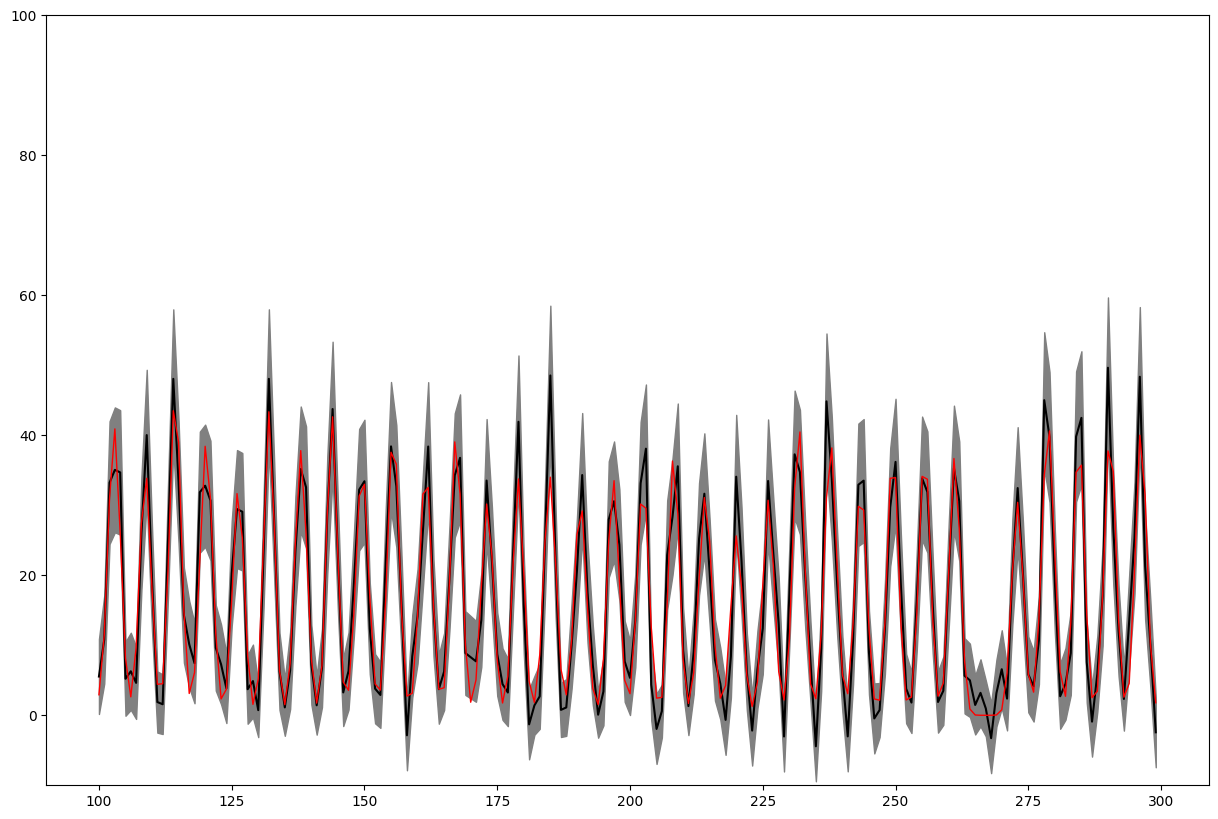

In [5]:
import numpy
from scipy import sparse
import matplotlib.pyplot as plt
from astropy.io import fits

fact = numpy.sqrt(2.0 * numpy.pi)

nfibers = 648
fiberpos = numpy.linspace(50,3950,nfibers+18,dtype=numpy.float32)  # 18 gaps
fiberpos = numpy.delete(fiberpos, slice(None, None, 37)) + numpy.random.normal(0,0.1,648)# make gaps!
ypix = numpy.arange(0, 4000, 1, dtype=numpy.float32) 
data = numpy.zeros(ypix.shape, dtype=numpy.float32)
sigma = numpy.ones(nfibers, dtype=numpy.float32)*2.5/2.35 + numpy.random.normal(0,0.05,fiberpos.shape)
fluxes = numpy.ones(nfibers, dtype=numpy.float32)*numpy.random.uniform(100,101, fiberpos.shape)

for f in range(nfibers):
    data += fluxes[f] * numpy.exp(-0.5 * ((ypix-fiberpos[f]) / sigma[f]) ** 2) / (fact * sigma[f])
data = numpy.random.poisson(data) + numpy.random.normal(0.0, 3.0, data.shape) # poisson noise + RN
errors = numpy.sqrt(data) + 3
errors[numpy.where( (errors<=0)+(~numpy.isfinite(errors)))] = 5

# table = numpy.genfromtxt('lsmr_test_data.txt', usecols=(0, 1, 2, 3))
# ypix = table[:,0]
# data = table[:,1]
# errors = table[:,2]
# mask = table[:,3]
# table = numpy.genfromtxt('lsmr_test_fibers.txt', usecols=(0, 1))
# fiberpos = table[:,0]
# sigma = table[:,1]
# nfibers = len(sigma)

def lsmr_python(ypix, pos, sigma, data, errors, vectorize=True):

    nfibers = len(fiberpos)
    # construct sparse projection matrix 
    fact = numpy.sqrt(2.0 * numpy.pi)
    kernel_width = 6 # should exceed 4 sigma

    if vectorize is False:
        vI = []
        vJ = []
        vV = []
        for xx in range(nfibers):
            for yy in range(int(pos[xx]-kernel_width),int(pos[xx]+kernel_width)+1):
                v = numpy.exp(-0.5 * ((yy-pos[xx]) / sigma[xx]) ** 2) / (fact * sigma[xx])
                if v>=0.0000:   # make non-zero and positive definite
                    vI.append(xx)
                    vJ.append(yy)
                    vV.append(v / errors[yy])
        B = sparse.csc_matrix((vV, (vJ, vI)), shape=(len(data), nfibers))
        #fits.writeto('B1.fits', B.toarray(), overwrite=True)    
    else:
        # nfibers x kernel_size
        xx = numpy.repeat(numpy.array(range(nfibers)), 2*kernel_width+1)
        # pixel ranges of fiber images
        pos_t = numpy.trunc(pos)
        yyv = numpy.linspace(pos_t-kernel_width, pos_t+kernel_width, 2*kernel_width+1, endpoint=True)
        # nfibers pixel values
        v = numpy.exp(-0.5 * ((yyv-pos) / sigma) ** 2) / (fact * sigma)
        yyv = yyv.T.flatten()
        v = v.T.flatten() / errors[yyv.astype(numpy.int32)]
        B = sparse.csc_matrix((v, (yyv, xx)), shape=(len(data), nfibers))
        #fits.writeto('B2.fits', B2.toarray(), overwrite=True)    

    # invert the projection matrix and solve
    guess_flux = numpy.interp(pos, ypix, data) * fact * sigma
    out = sparse.linalg.lsmr(B, data / errors, atol=1e-6, btol=1e-6, x0=guess_flux, show=False)
    flux = out[0]
    return flux

#%load_ext line_profiler
#%lprun -f lsmr_python for i in range(500): flux=lsmr_python(ypix, fiberpos, sigma, data, errors)
flux=lsmr_python(ypix, fiberpos, sigma, data, errors)
model = numpy.zeros(data.shape)
#plt.plot(fluxes, flux, 'b.')
plt.figure(figsize=(15, 10))
for f in range(nfibers):
    model += flux[f] * numpy.exp(-0.5 * ((ypix-fiberpos[f]) / sigma[f]) ** 2) / (fact * sigma[f])
i1 = 100
i2 = 300
plt.gca().fill_between(ypix[i1:i2], data[i1:i2]-errors[i1:i2], data[i1:i2]+errors[i1:i2], color='gray')
plt.plot(ypix[i1:i2], data[i1:i2], color='black')
plt.plot(ypix[i1:i2], model[i1:i2], color='red', linewidth=1)
plt.ylim(-10,100)
print(numpy.sum(((model-data)/errors) ** 2) / len(data))
